# VAS data

This is just an example workflow that shows how to :
1. [Analyse amount of errors and relative failing glacier area when no glacier_statistics.csv files were calculated beforehand](#For-simplifications,-let's-just-look-at-the-errors-from-a-single-GCM-and-SSP!)
2. Compare the future common non-failing glacier volumes of different calibration methods (globally and regionally):
    - a) [for one gcm and one ssp](#Volume-projections-for-common-non-failing-glaciers-for-one-gcm-and-one-ssp)
    - b) [for all gcms and one ssp by looking at the mean and standard deviation](#Volume-projections-for-common-non-failing-glaciers-for-all-gcms-that-work-for-the-lowest-emission-ssp-scenario-ssp126)

**Here we look at these three different calibration options:**

cmip6_old_output:
   - CRU with regional geodetic MB calib and QC3
      - match_geod_qc3
    
cmip6_output: 
   - CRU with glacier-specific geodetic MB calib and QC0  
     - match_geod_per_glac_qc0
    
cmip6_output_massredis:
   - CRU with glacier specific geodetic MB calib and mass redistribution instead of SIA and QC0
     - match_geod_per_glac_massredis_qc0

---

In [1]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/home/users/lschuster/.local/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
gcms = os.listdir('/home/www/fmaussion/vas_paper/runs_cmip6_cru/cmip6_output_massredis/RGI01')
ssps = ['ssp126','ssp245', 'ssp370', 'ssp585'] 



### For simplifications, let's just look at the errors from a single GCM and SSP!

In [4]:
# as an example:
#gcm = 'BCC-CSM2-MR'
gcm = 'NorESM2-MM'
#gcm = 'CESM2'
ssp = 'ssp126'

In [5]:
def error_stats_working_rgi(gcm = 'BCC-CSM2-MR', ssp = 'ssp585'):
    
    convert_dict = {'cmip6_output_massredis': 'match_geod_per_glac_massredis_qc0',
                           'cmip6_output':'match_geod_per_glac_qc0',
                           'cmip6_old_output': 'match_geod_qc3'}
    pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
    # we do not model RGI region 19 here ... 
    pd_geodetic = pd_geodetic[pd_geodetic.reg != 19]

    
    total_area = pd_geodetic.area.sum()
    total_counts = len(pd_geodetic)
    # pd_geodetic.area
    pd_error = pd.DataFrame(index = pd_geodetic.index,
                            columns=['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output', 'area', 'all_running'])
    pd_error['area'] = pd_geodetic.area
    pd_error['all_running'] = np.NaN


    for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
        working_rgis = []
        # get working glaciers for each rgi and get a global list of working glaciers
        for n in np.arange(1,19,1):
            if n<10:
                rgi_reg = f'RGI0{n}'
            else:
                rgi_reg = f'RGI{n}'
            ds = xr.open_dataset(f'/home/www/fmaussion/vas_paper/runs_cmip6_cru/{cmip6_output_type}/{rgi_reg}/{gcm}/{gcm}_{ssp}.nc').volume.dropna(dim='rgi_id')
            working_rgi = ds.isel(time=0).dropna(dim='rgi_id').rgi_id.values
            working_rgis.append(working_rgi)
            ds.close()
        working_rgis = np.concatenate(working_rgis)

        # pd_error[cmip6_output_type] = False
        # set those glaciers that worked to true, the other are NaN
        pd_error.loc[working_rgis,cmip6_output_type] = True
        # check if it worked
        assert len(working_rgis) == len(pd_error.loc[pd_error[cmip6_output_type] == True])
        #print(len(working_rgis))
    # this is slower
    #for rgi in working_rgis:
    #    if rgi in pd_test.index:
    #        pd_test.loc[rgi][cmip6_output_type] = True

    # get those glaciers that work for all experiment variants ('but only for that ssp and gcm'!!!)
    all_running_rgis = pd_error[['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']].dropna()
    pd_error.loc[all_running_rgis.index, 'all_running'] = True
    # len(pd_error['all_running'].dropna()) <= 

    # get relative glacier area that works
    pd_error_stats = {}
    for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
        pd_error_stats[f'{convert_dict[cmip6_output_type]}_area'] = (1-(pd_error.loc[pd_error[cmip6_output_type].dropna().index]['area'].sum())/total_area)*100
    pd_error_stats['all_running_area'] = (1-(pd_error.loc[pd_error['all_running'].dropna().index]['area'].sum())/total_area)*100
    for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
        pd_error_stats[f'{convert_dict[cmip6_output_type]}_counts'] = (1-len(pd_error[cmip6_output_type].dropna().index)/total_counts)*100
    pd_error_stats['all_running_counts'] = (1-len(pd_error['all_running'].dropna().index)/total_counts)*100
    
    pd_error_rgi_stats = {}
    for reg in set(pd_geodetic.reg):
        pd_error_rgi_stats_reg = {}
        rgi_reg = pd_geodetic.loc[pd_geodetic.reg==reg].index
        total_reg_area = pd_geodetic.loc[pd_geodetic.reg==reg].area.sum()
        total_reg_counts = len(pd_geodetic.loc[pd_geodetic.reg==reg])

        pd_error.loc[rgi_reg, 'reg'] = reg
        for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
            pd_error_rgi_stats_reg[f'{convert_dict[cmip6_output_type]}_area'] = (1-(pd_error.loc[pd_error.loc[rgi_reg][cmip6_output_type].dropna().index]['area'].sum())/total_reg_area)*100
        pd_error_rgi_stats_reg['all_running_area'] = (1-(pd_error.loc[pd_error.loc[rgi_reg]['all_running'].dropna().index]['area'].sum())/total_reg_area)*100
        for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
            pd_error_rgi_stats_reg[f'{convert_dict[cmip6_output_type]}_counts'] = (1-len(pd_error.loc[pd_error.loc[rgi_reg][cmip6_output_type].dropna().index])/total_reg_counts)*100
        pd_error_rgi_stats_reg['all_running_counts'] = (1-len(pd_error.loc[pd_error.loc[rgi_reg]['all_running'].dropna().index])/total_reg_counts)*100
        pd_error_rgi_stats[str(reg)] = pd_error_rgi_stats_reg

    #return pd_error_stats, pd_error, pd_error_rgi_stats
    pd_error_rgi_stats = pd.DataFrame(pd_error_rgi_stats)
    pd_error_rgi_stats['all'] = pd.DataFrame(pd_error_stats, index=[0]).T[0] #pd_error_stats
    return pd_error_stats, pd_error, pd_error_rgi_stats

In [6]:
cmip6_output_type = 'cmip6_output_massredis'
rgi_reg = 'RGI01'
xr.open_dataset(f'/home/www/fmaussion/vas_paper/runs_cmip6_cru/{cmip6_output_type}/{rgi_reg}/{gcm}/{gcm}_{ssp}.nc').volume.dropna(dim='rgi_id')

/home/users/lschuster/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'volume' (time: 82, rgi_id: 27080)>
array([[5.755895e+06, 1.527717e+07, 4.210734e+07, ..., 1.067689e+08,
        3.436057e+07, 1.805127e+06],
       [5.627826e+06, 1.499158e+07, 4.002556e+07, ..., 1.009200e+08,
        3.218732e+07, 1.687626e+06],
       [5.598141e+06, 1.484801e+07, 3.837280e+07, ..., 9.553950e+07,
        3.032915e+07, 1.597355e+06],
       ...,
       [1.763794e+06, 3.596061e+06, 1.764006e+05, ..., 1.712339e+07,
        5.545750e+06, 0.000000e+00],
       [1.722843e+06, 3.471366e+06, 1.568110e+05, ..., 1.672752e+07,
        5.437562e+06, 0.000000e+00],
       [1.691012e+06, 3.376146e+06, 1.378086e+05, ..., 1.707277e+07,
        5.520620e+06, 0.000000e+00]], dtype=float32)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) object 'RGI60-01.00001' ... 'RGI60-01.27112'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Attributes:
    description:  Total glacier volume
    unit:         m 3

In [7]:
pds_error_stats = {}
pds_error = {}
pds_error_rgi_stats = {}

pds_error_stats[f'{gcm}_{ssp}'], pds_error[f'{gcm}_{ssp}'], pds_error_rgi_stats[f'{gcm}_{ssp}'] = error_stats_working_rgi(gcm = gcm, ssp = ssp)

In [8]:
pds_error_rgi_stats[f'{gcm}_{ssp}'].iloc[:4]

1         2         3  \
match_geod_per_glac_massredis_qc0_area  0.004060  0.012689  0.020457   
match_geod_per_glac_qc0_area            0.002438  0.007773  0.014666   
match_geod_qc3_area                     0.004393  0.029007  0.143415   
all_running_area                        0.008453  0.041999  0.161030   

                                               4          5         6  \
match_geod_per_glac_massredis_qc0_area  0.031843   0.388694  0.002450   
match_geod_per_glac_qc0_area            0.029387   0.247575  9.655949   
match_geod_qc3_area                     0.000942  12.742051  0.000000   
all_running_area                        0.034607  12.984928  9.656826   

                                               7         8         9  \
match_geod_per_glac_massredis_qc0_area  0.445790  0.003391  1.784461   
match_geod_per_glac_qc0_area            1.728935  0.003391  0.063121   
match_geod_qc3_area                     0.000000  0.003391  0.000000   
all_running_area                        2.174725  0.003391  1.800247   

                                              10        11        12  \
match_geod_per_glac_massredis_qc0_area  3.576024  0.017876  9.125319   
match_geod_per_glac_qc0_area            3.597891  0.007934  9.124293   
match_geod_qc3_area                     3.513287  0.007934  9.236786   
all_running_area                        3.615193  0.017876  9.237812   

                                              13        14        15  \
match_geod_per_glac_massredis_qc0_area  6.134486  0.178508  0.167026   
match_geod_per_glac_qc0_area            5.419207  0.072792  0.099130   
match_geod_qc3_area                     1.744749  0.037249  0.758887   
all_running_area                        6.850611  0.217342  0.924373   

                                              16        17        18       all  
match_geod_per_glac_massredis_qc0_area  0.000641  4.780309  0.009812  1.081192  
match_geod_per_glac_qc0_area            0.000641  0.270851  0.000000  0.864427  
match_geod_qc3_area                     7.549307  5.023888  0.000000  2.520817  
all_running_area                        7.549307  9.802862  0.009812  3.743180

Text(0.5, 15.0, 'RGI region (without RGI region 19)')

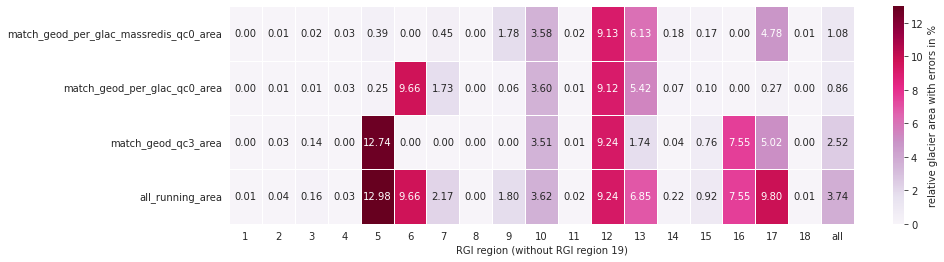

In [9]:
plt.figure(figsize=(14,4))
sns.heatmap(pds_error_rgi_stats[f'{gcm}_{ssp}'].iloc[:4],
            linewidths=.5,  cmap="PuRd", cbar_kws={'label':'relative glacier area with errors in %'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.set_xlabel('RGI region (without RGI region 19)')

Text(0.5, 15.0, 'RGI region (without RGI region 19)')

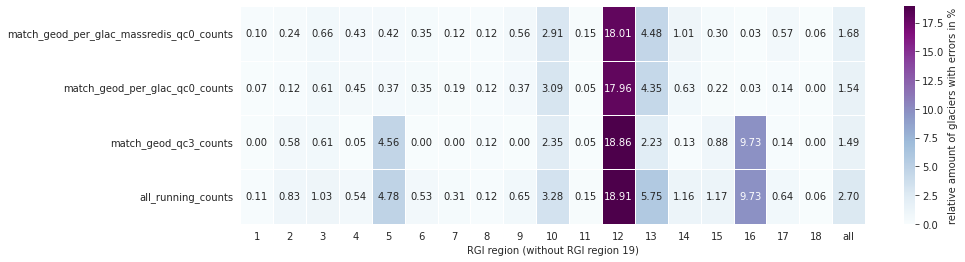

In [10]:
plt.figure(figsize=(14,4))
sns.heatmap(pds_error_rgi_stats[f'{gcm}_{ssp}'].iloc[4:8], linewidths=.5,  cmap="BuPu",
            cbar_kws={'label':'relative amount of glaciers with errors in %'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.set_xlabel('RGI region (without RGI region 19)')

In [11]:
pd_all_vas_example = pd.DataFrame(pds_error_rgi_stats[f'{gcm}_{ssp}']['all'].iloc[:3])
pd_all_vas_example['qc'] = ['qc0','qc0','qc3']
pd_all_vas_example['exp'] = 'elev_bands'
pd_all_vas_example['clim_pcp'] = 'CRU_pcp2.5'
pd_all_vas_example = pd_all_vas_example.rename(columns={'all':'rel_error_area_in_percent'})
pd_all_vas_example['match'] = pd_all_vas_example.index
pd_all_vas_example = pd_all_vas_example[::-1] 

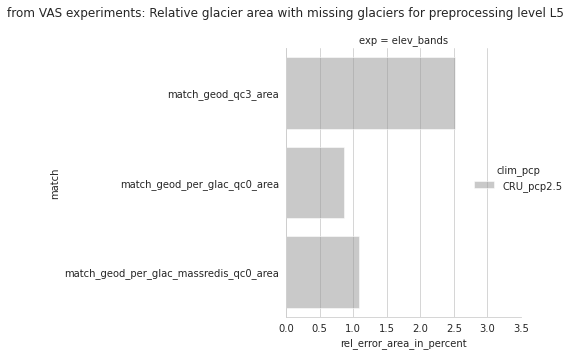

In [12]:
sns.set_style("whitegrid")

sns.catplot(y="match", x="rel_error_area_in_percent", data=pd_all_vas_example,
            hue='clim_pcp', orient='h', col='exp',
           kind='bar', alpha=0.5, palette='Greys', aspect=1.1) #['Black', 'Grey'])
plt.xlim([0,3.5])
plt.suptitle("from VAS experiments: Relative glacier area with missing glaciers for preprocessing level L5")
plt.tight_layout();

## Volume projections for common non-failing glaciers for one gcm and one ssp

In [13]:
# this is the list of glaciers that runs for all VAS projections of this gcm and ssp
all_running_rgis_vas = pds_error[f'{gcm}_{ssp}']['all_running'].dropna().index
len(all_running_rgis_vas)

207048

In [14]:
cmip6_output_type = 'cmip6_output_massredis'
ds_cmip6 = {}

for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
    ds = []
    for n in np.arange(1,19,1):
        if n<10:
            rgi_reg = f'RGI0{n}'
        else:
            rgi_reg = f'RGI{n}'
        ds_reg = xr.open_dataset(f'/home/www/fmaussion/vas_paper/runs_cmip6_cru/{cmip6_output_type}/{rgi_reg}/{gcm}/{gcm}_{ssp}.nc').volume.dropna(dim='rgi_id')
        ds.append(ds_reg)
    ds = xr.concat(ds, dim='rgi_id')
    ds = ds.sel(rgi_id = all_running_rgis_vas)
    ds_cmip6[cmip6_output_type] = ds



Text(0, 0.5, '% of volume in 2020 (compared to match_geod_per_glac)')

<Figure size 1440x720 with 0 Axes>

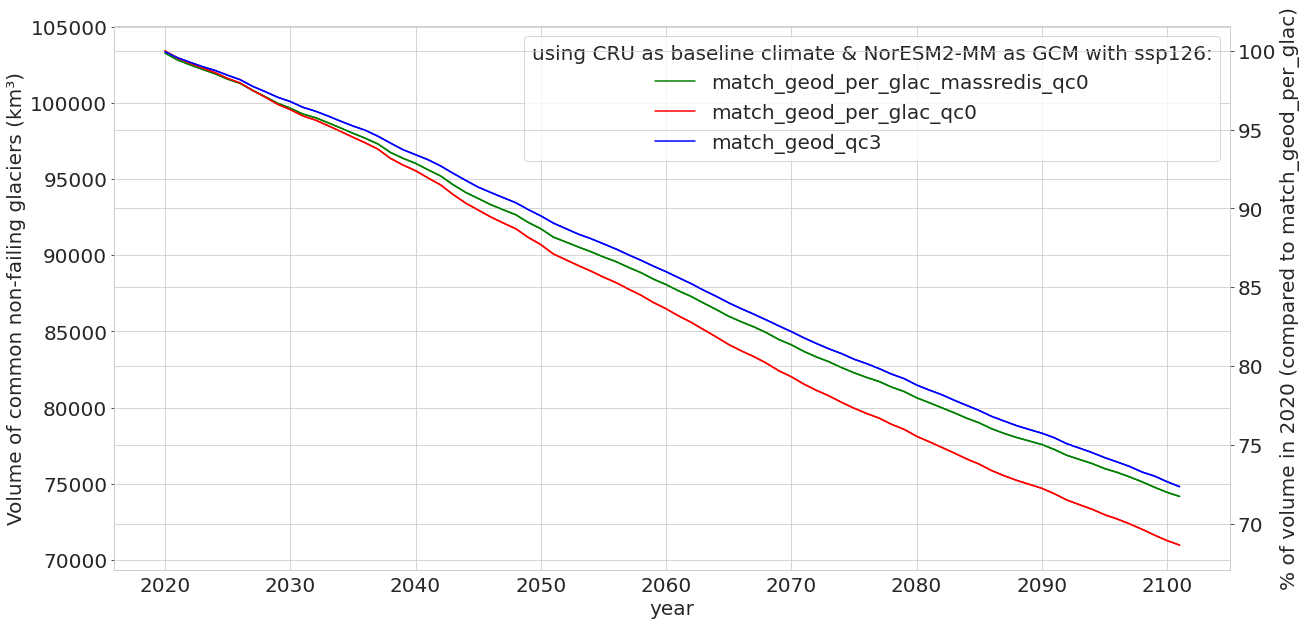

In [15]:
plt.figure(figsize=(20,10))
plt.rc('font', size=20)
convert_dict = {'cmip6_output_massredis': 'match_geod_per_glac_massredis_qc0',
                           'cmip6_output':'match_geod_per_glac_qc0',
                           'cmip6_old_output': 'match_geod_qc3'}
colors = ['green', 'red', 'blue']
fig, ax = plt.subplots(figsize=(20,10))
for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    ax.plot(ds_cmip6[cmip6_output_type].time, #hydro_year,
            ds_cmip6[cmip6_output_type].sum(dim='rgi_id')/1e9, label = convert_dict[cmip6_output_type], color = colors[j])
    
ax.legend(title=f'using CRU as baseline climate & {gcm} as GCM with {ssp}:')
plt.ylabel('Volume of common non-failing glaciers (km³)')
plt.xlabel('year')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    ax2.plot(ds_cmip6[cmip6_output_type].time, #hydro_year,
             (ds_cmip6[cmip6_output_type].sum(dim='rgi_id')*100)/ds_cmip6['cmip6_output'].sum(dim='rgi_id').sel(time=2020),
             label = convert_dict[cmip6_output_type], color = colors[j])
plt.ylabel('% of volume in 2020 (compared to match_geod_per_glac)')


<a id='id-volume-proj-single-gcm'></a>

In [16]:
print('final % of volume in 2100 compared to 2020:')
for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    print(cmip6_output_type)
    print(((ds_cmip6[cmip6_output_type].sum(dim='rgi_id').sel(time=2100)*100)/ds_cmip6['cmip6_output'].sum(dim='rgi_id').sel(time=2020)).values)

final % of volume in 2100 compared to 2020:
cmip6_output_massredis
71.98520309043914
cmip6_output
68.92377240722911
cmip6_old_output
72.65960918565486


**zoom into the first 10 years:**

Text(0, 0.5, 'Volume of common non-failing glaciers (km³)')

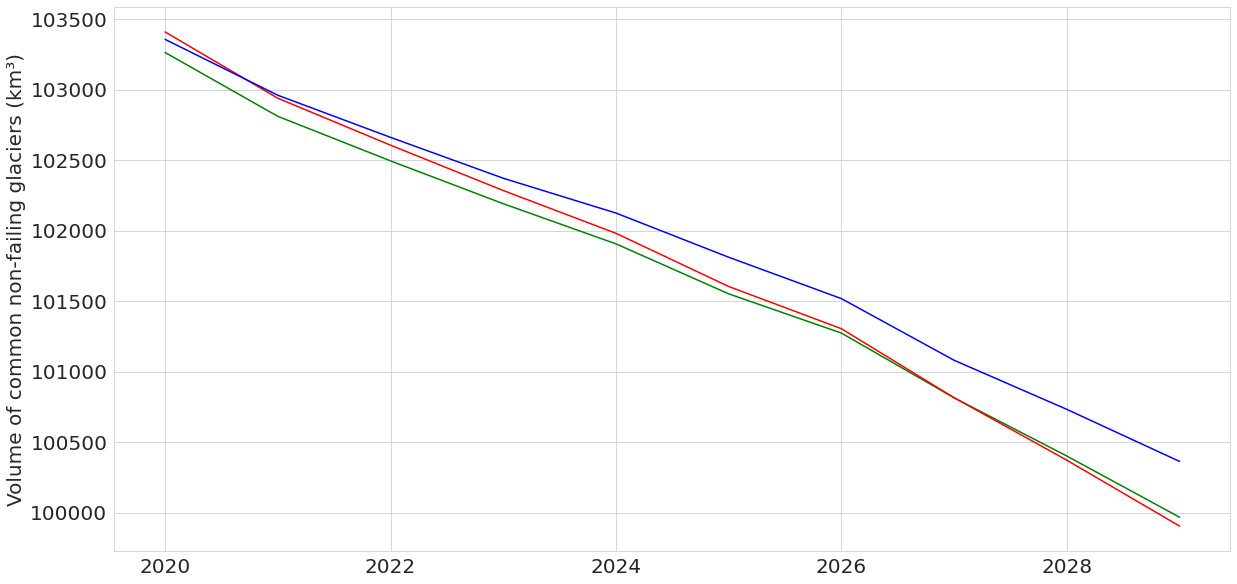

In [17]:
plt.figure(figsize=(20,10))

for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    plt.plot(ds_cmip6[cmip6_output_type].time[:10], #hydro_year,
            (ds_cmip6[cmip6_output_type].sum(dim='rgi_id')/1e9)[:10], label = convert_dict[cmip6_output_type], color = colors[j])
plt.ylabel('Volume of common non-failing glaciers (km³)')


When looking only at the common non-failing glaciers:
- at the beginning, the volume is similar for "match_geod_per_glac" using SIA and using mass-redistribution, 
    - however, volume loss rates are larger with SIA compare to the mass-redistribution curves, which results later in a much higher volume using mass-redistribution curves compared to SIA
- only matching the geodetic estimates regionally ("match_geod") is already from the beginning on different to the other match options
    - using "match_geod" instead of "match_geod_pergla", both with SIA, results in 2100 in a around 13% larger glacier volume (for the "CESM2 GCM" and the lowest-emission ssp scenario) 
    - would need to repeat this for all GCMs but it will be approximately the same for the others (would need to update then the all_running glacier lists !!!)

In [20]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
# we do not model RGI region 19 here ... 
pd_geodetic = pd_geodetic[pd_geodetic.reg != 19]

/tmp/ipykernel_561358/3913829592.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


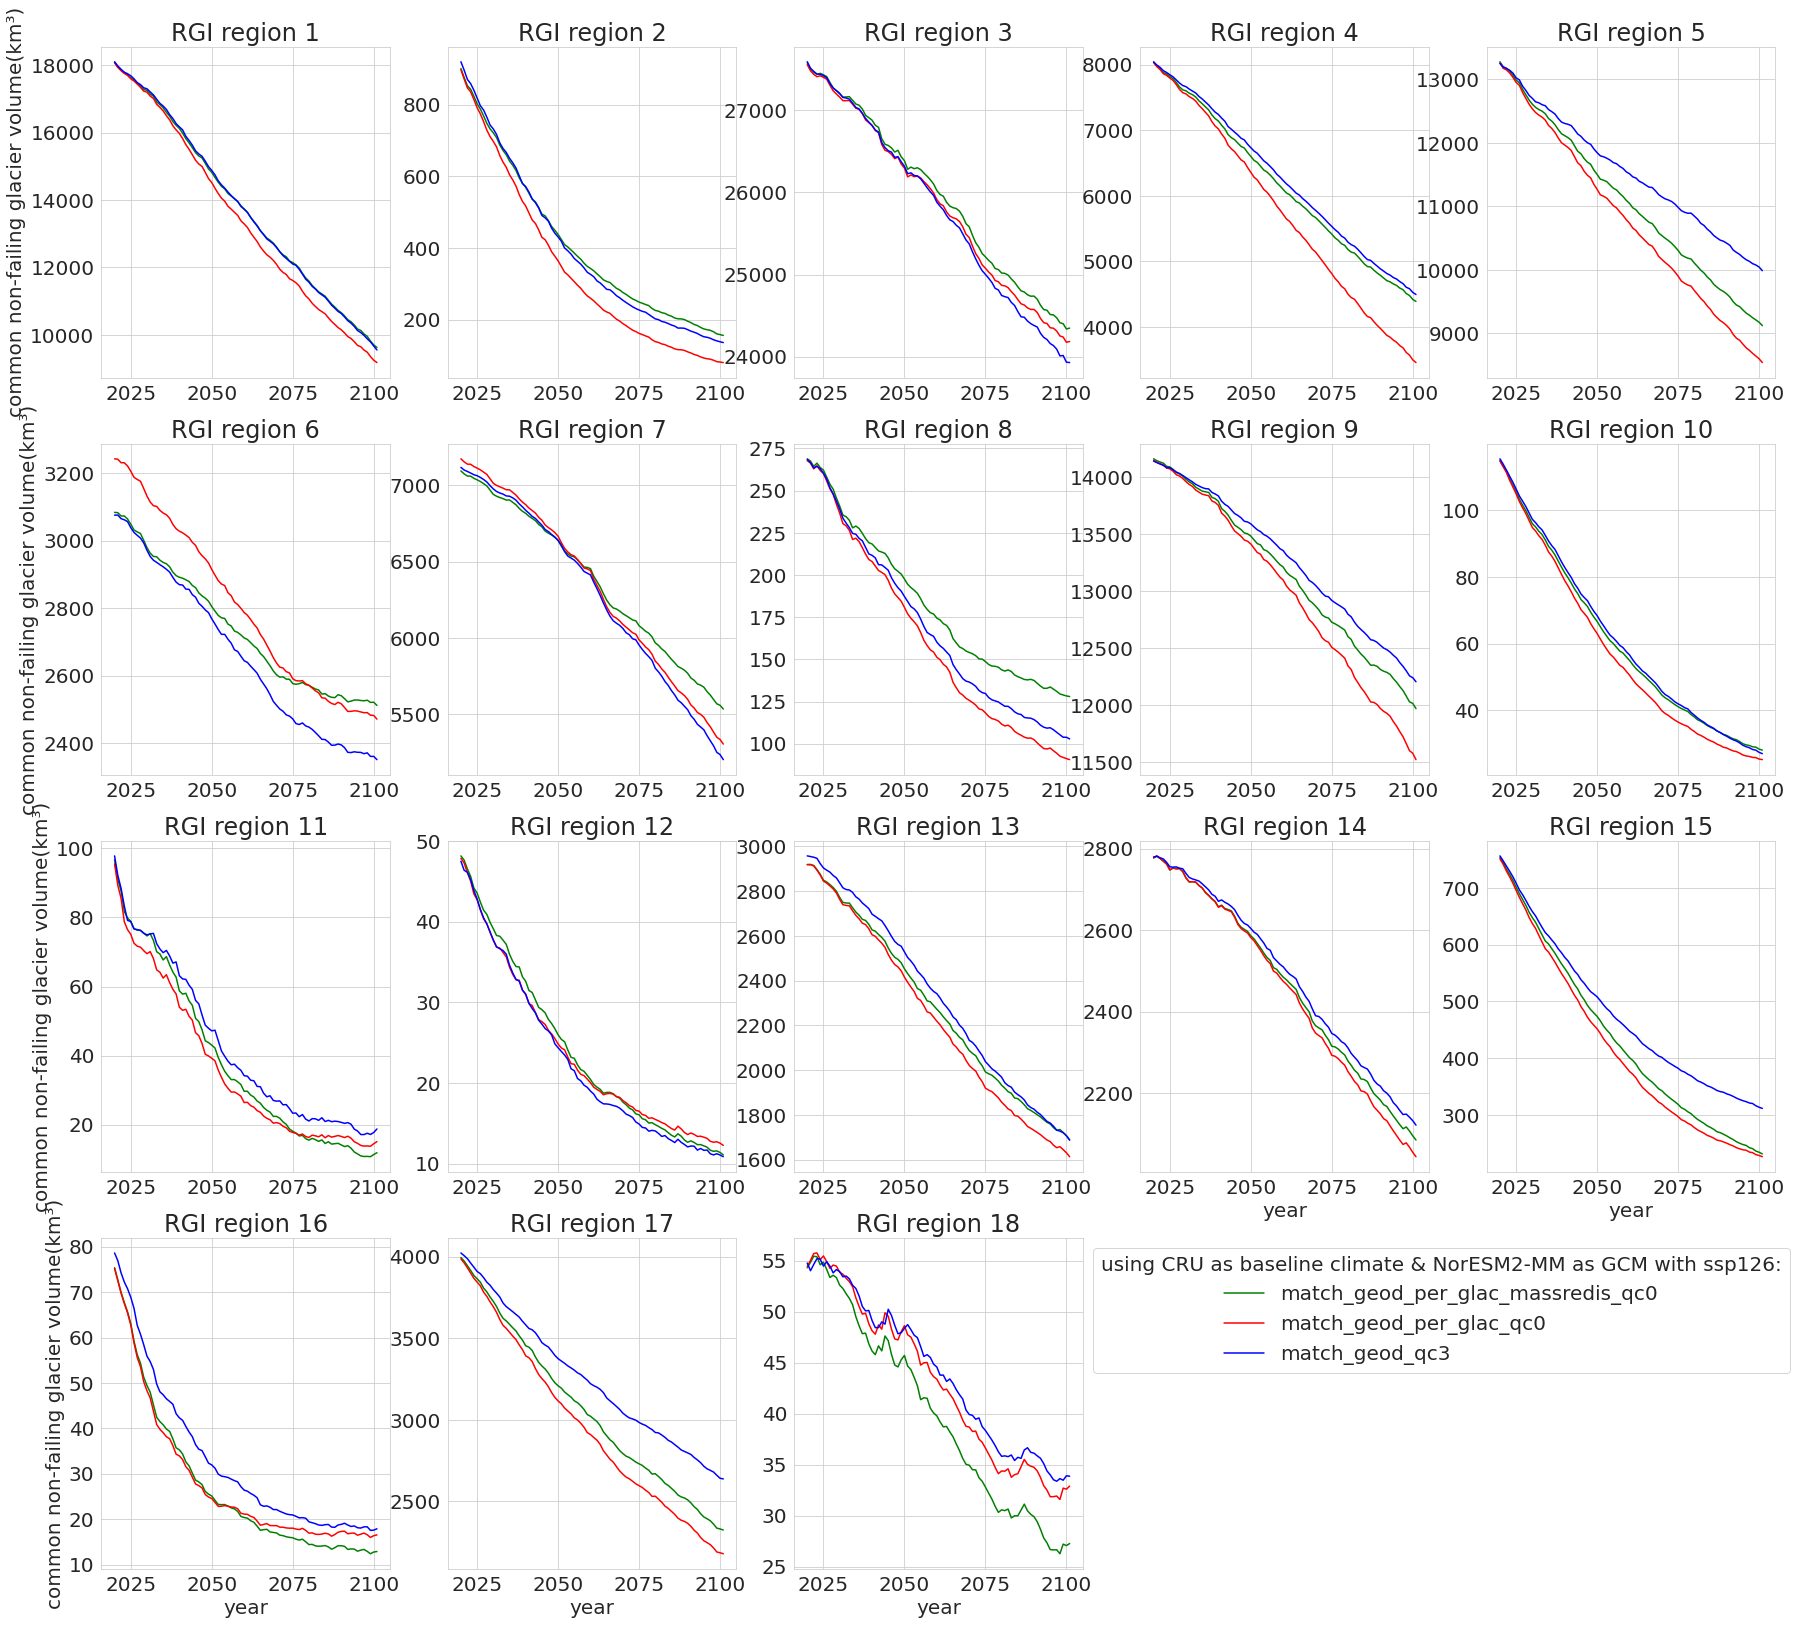

In [48]:
plt.figure(figsize=(30,28))
for reg in np.arange(1,19,1):
    plt.subplot(4,5,reg)
    ax = plt.gca()
    all_running_rgis_vas_reg_gcm = pd_geodetic.loc[all_running_rgis_vas].loc[pd_geodetic.loc[all_running_rgis_vas].reg == reg].index
    
    
    for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
        ax.plot(ds_cmip6[cmip6_output_type].sel(rgi_id = all_running_rgis_vas_reg_gcm).time, #hydro_year,
                ds_cmip6[cmip6_output_type].sel(rgi_id = all_running_rgis_vas_reg_gcm).sum(dim='rgi_id')/1e9,
                label = convert_dict[cmip6_output_type], color = colors[j])
        plt.title(f'RGI region {reg}')
    if reg == 18:
        ax.legend(title=f'using CRU as baseline climate & {gcm} as GCM with {ssp}:', loc = 'upper left', bbox_to_anchor=(1,1))
    if reg == 1 or reg ==6 or reg ==11 or reg==16:
        plt.ylabel('common non-failing glacier volume(km³)')
    if reg >=14:
        plt.xlabel('year')
plt.tight_layout()

## Volume projections for common non-failing glaciers for all gcms that work for the lowest-emission ssp scenario ssp126

Let's first select those glaciers that work for all gcms of ssp126!

In [49]:
for gcm in gcms:
    try:
        pds_error_stats[f'{gcm}_{ssp}'], pds_error[f'{gcm}_{ssp}'], pds_error_rgi_stats[f'{gcm}_{ssp}'] = error_stats_working_rgi(gcm = gcm, ssp = ssp)
    except:
        pass


all_running_rgis_vas = {}
for gcm in gcms:
    try:
        all_running_rgis_vas[gcm] = pds_error[f'{gcm}_{ssp}']['all_running'].dropna().index
    except:
        pass


In [50]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
# we do not model RGI region 19 here ... 
pd_geodetic = pd_geodetic[pd_geodetic.reg != 19]

pd_all_running_rgis_vas = pd.DataFrame(np.NaN, index=pd_geodetic.index, columns = gcms)
#pd_all_running_rgis_vas.index = pd_all_running_rgis_vas.rgiid
gcm_drop = []
for gcm in gcms:
    try:
        pd_all_running_rgis_vas.loc[all_running_rgis_vas[gcm], gcm] = True
    except:
        gcm_drop.append(gcm)
        pass
pd_all_running_rgis_vas = pd_all_running_rgis_vas.drop(columns=gcm_drop)
all_running_rgis_vas_all_gcms = pd_all_running_rgis_vas.dropna(how='any').index

In [51]:
running_gcms = pd_all_running_rgis_vas.columns

In [52]:
ds_cmip6_all_gcms = {}

for cmip6_output_type in ['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']:
    ds_gcms = []
    for gcm in running_gcms:
        ds = []
        for n in np.arange(1,19,1):
            if n<10:
                rgi_reg = f'RGI0{n}'
            else:
                rgi_reg = f'RGI{n}'
            ds_reg = xr.open_dataset(f'/home/www/fmaussion/vas_paper/runs_cmip6_cru/{cmip6_output_type}/{rgi_reg}/{gcm}/{gcm}_{ssp}.nc').volume.dropna(dim='rgi_id')
            ds.append(ds_reg)
            ds_reg.close()
        ds = xr.concat(ds, dim='rgi_id')
        ds = ds.sel(rgi_id = all_running_rgis_vas_all_gcms)
        ds.coords['gcm'] = gcm
        ds_gcms.append(ds)
    
    ds_gcms_f = xr.concat(ds_gcms, 'gcm')
    ds_cmip6_all_gcms[cmip6_output_type] = ds_gcms_f
        



<a id='id-volume-proj-all-gcms'></a>

**Global plot without RGI region 19**

Text(0.5, 0, 'year')

<Figure size 1440x720 with 0 Axes>

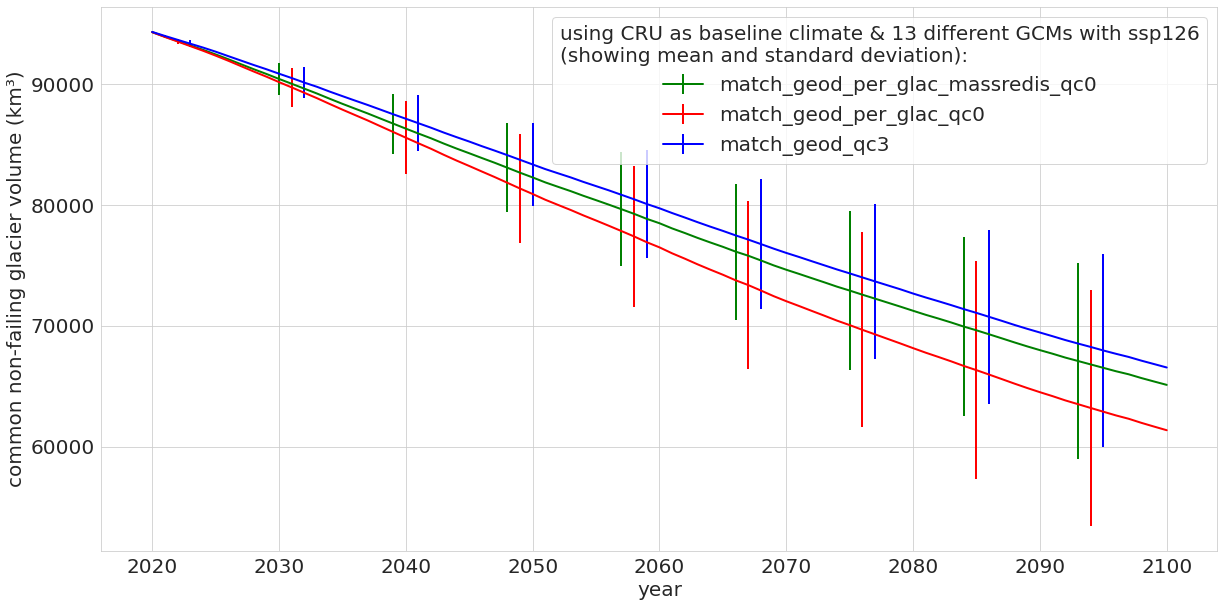

In [60]:
plt.figure(figsize=(20,10))
convert_dict = {'cmip6_output_massredis': 'match_geod_per_glac_massredis_qc0',
                           'cmip6_output':'match_geod_per_glac_qc0',
                           'cmip6_old_output': 'match_geod_qc3'}
colors = ['green', 'red', 'blue']
fig, ax = plt.subplots(figsize=(20,10))
for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    ax.errorbar(x=ds_cmip6_all_gcms[cmip6_output_type].time.sel(time=np.arange(2020,2101,1)), #hydro_year,
        y=ds_cmip6_all_gcms[cmip6_output_type].sel(time=np.arange(2020,2101,1)).sum(dim='rgi_id').mean(dim='gcm')/1e9,
                yerr=ds_cmip6_all_gcms[cmip6_output_type].sel(time=np.arange(2020,2101,1)).sum(dim='rgi_id').std(dim='gcm')/1e9,
        label = convert_dict[cmip6_output_type], color = colors[j], linewidth=2, alpha = 1, errorevery=(j+1,9))
plt.legend(title=f'using CRU as baseline climate & 13 different GCMs with {ssp}\n(showing mean and standard deviation):')
plt.ylabel('common non-failing glacier volume (km³)')
plt.xlabel('year')

**Regional plot**

/tmp/ipykernel_561358/703582253.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


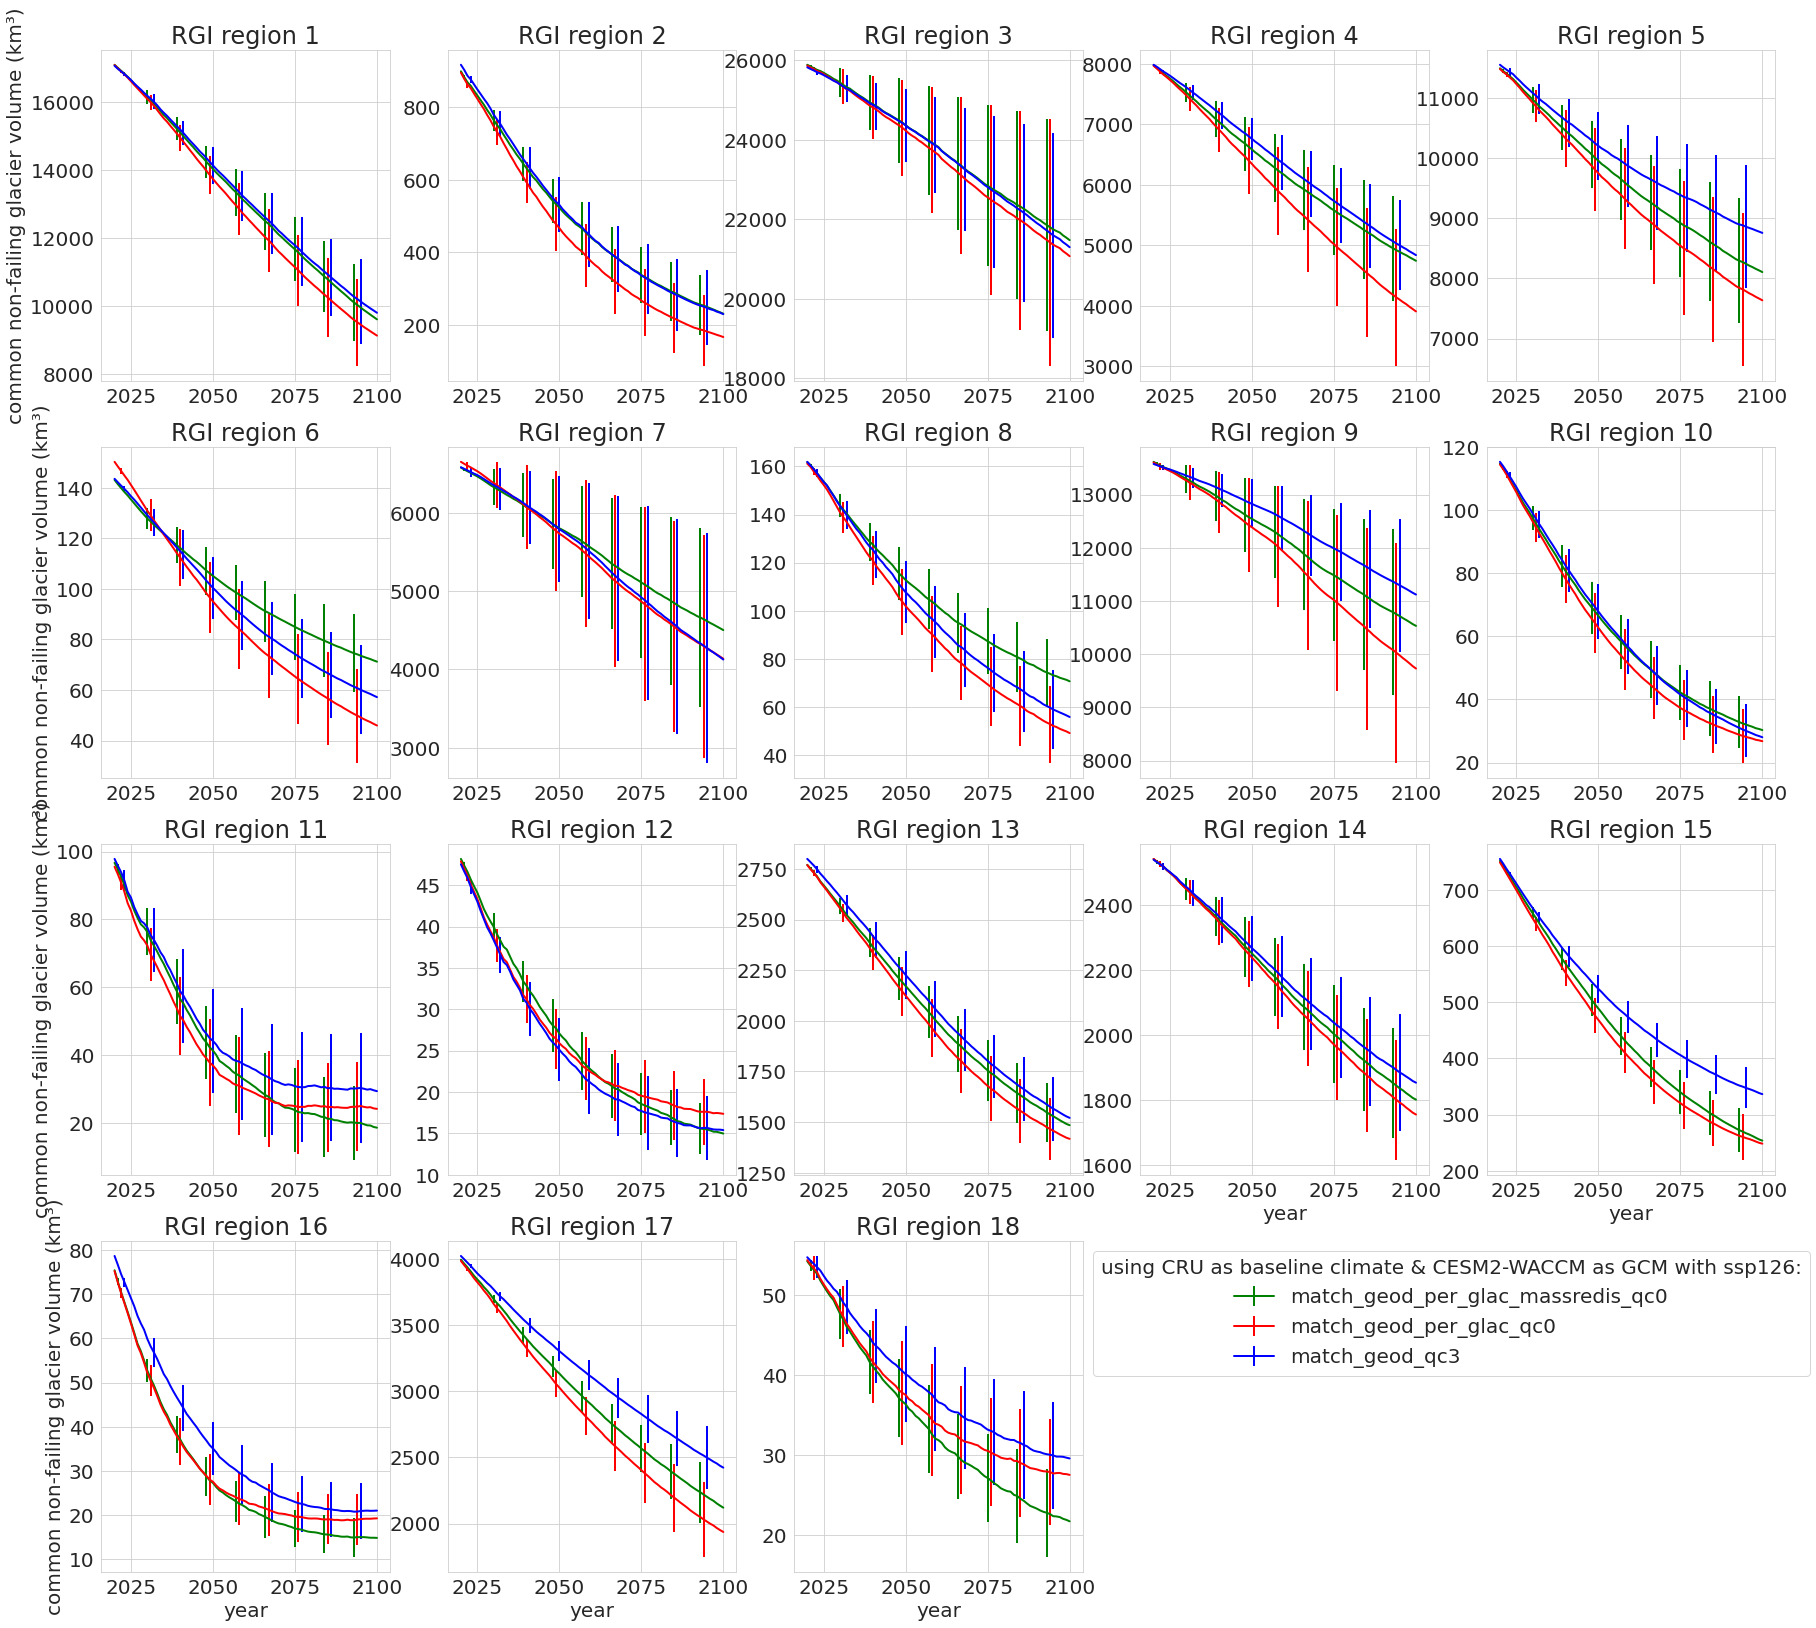

In [57]:
plt.figure(figsize=(30,28))
for reg in np.arange(1,19,1):
    plt.subplot(4,5,reg)
    ax = plt.gca()
    all_running_rgis_vas_all_gcms_reg = pd_geodetic.loc[all_running_rgis_vas_all_gcms].loc[pd_geodetic.loc[all_running_rgis_vas_all_gcms].reg == reg].index
    
    
    for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
        ax.errorbar(x=ds_cmip6_all_gcms[cmip6_output_type].time.sel(time=np.arange(2020,2101,1)), #hydro_year,
            y=ds_cmip6_all_gcms[cmip6_output_type].sel(time=np.arange(2020,2101,1)).sel(rgi_id=all_running_rgis_vas_all_gcms_reg).sum(dim='rgi_id').mean(dim='gcm')/1e9,
                    yerr=ds_cmip6_all_gcms[cmip6_output_type].sel(time=np.arange(2020,2101,1)).sel(rgi_id=all_running_rgis_vas_all_gcms_reg).sum(dim='rgi_id').std(dim='gcm')/1e9,
            label = convert_dict[cmip6_output_type], color = colors[j], linewidth=2, alpha = 1, errorevery=(j+1,9))
        plt.title(f'RGI region {reg}')
    if reg == 18:
        ax.legend(title=f'using CRU as baseline climate & {gcm} as GCM with {ssp}:', loc = 'upper left', bbox_to_anchor=(1,1))
    if reg == 1 or reg ==6 or reg ==11 or reg==16:
        plt.ylabel('common non-failing glacier volume (km³)')
    if reg >=14:
        plt.xlabel('year')
plt.tight_layout()

Text(0.5, 0, 'year')

<Figure size 1440x720 with 0 Axes>

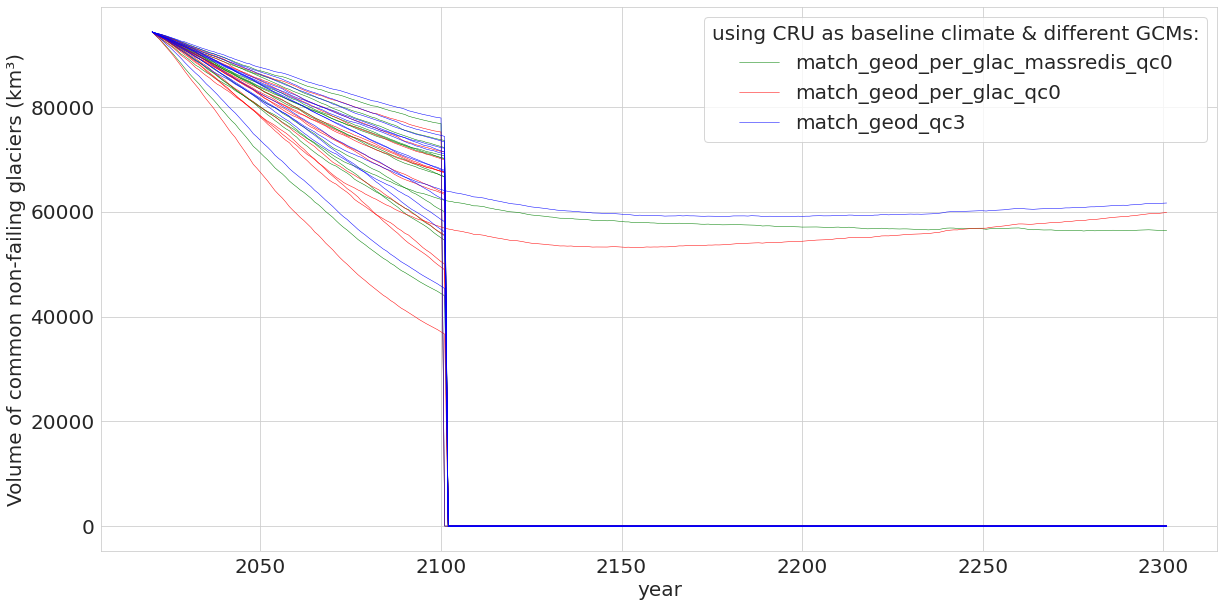

In [52]:
plt.figure(figsize=(20,10))
convert_dict = {'cmip6_output_massredis': 'match_geod_per_glac_massredis_qc0',
                           'cmip6_output':'match_geod_per_glac_qc0',
                           'cmip6_old_output': 'match_geod_qc3'}
colors = ['green', 'red', 'blue']
fig, ax = plt.subplots(figsize=(20,10))
for j,cmip6_output_type in enumerate(['cmip6_output_massredis', 'cmip6_output', 'cmip6_old_output']):
    for f, gcm in enumerate(running_gcms):
        if f== 0:   
            ax.plot(ds_cmip6_all_gcms[cmip6_output_type].time, #hydro_year,
                (ds_cmip6_all_gcms[cmip6_output_type].sum(dim='rgi_id')/1e9).sel(gcm=f), #gcm),
                label = convert_dict[cmip6_output_type], color = colors[j], linewidth=0.5)
            ax.legend(title=f'using CRU as baseline climate & different GCMs:')
        else:
            ax.plot(ds_cmip6_all_gcms[cmip6_output_type].time, #hydro_year,
                (ds_cmip6_all_gcms[cmip6_output_type].sum(dim='rgi_id')/1e9).sel(gcm=f), #gcm),
                color = colors[j], linewidth=0.5)
            
plt.ylabel('Volume of common non-failing glaciers (km³)')


plt.xlabel('year')